In [ ]:
from flair.data import Corpus
from flair.datasets import CSVClassificationCorpus
from flair.embeddings import WordEmbeddings, FlairEmbeddings, DocumentRNNEmbeddings
from flair.models import TextClassifier
from flair.trainers import ModelTrainer

Define the data/output folders and use Flair's builtin functionality to read the corpus.

In [1]:
data_folder = '../../data/processed/flairdata/'
outputs_folder = "../../data/outputs/flair/"

column_name_map = {0: "text", 1: "label"}

corpus: Corpus = CSVClassificationCorpus(data_folder,
                                         column_name_map,
                                         skip_header=True,
                                        dev_file='val.csv'# tab-separated files
) 

2020-06-13 10:05:28,029 Reading data from flairdata
2020-06-13 10:05:28,030 Train: flairdata/train.csv
2020-06-13 10:05:28,030 Dev: flairdata/val.csv
2020-06-13 10:05:28,031 Test: flairdata/test.csv


- We can use the make label dictionary function to create the vocabulary.
- We will be using GLOVE embeddings, along with FlairEmbeddings our models.

In [2]:
# create the label dictionary
label_dict = corpus.make_label_dictionary()

# make a list of word embeddings
word_embeddings = [
    WordEmbeddings('glove'),
    # comment in these lines to use flair embeddings
    FlairEmbeddings('news-forward'),
    FlairEmbeddings('news-backward'),
]

2020-06-13 10:05:31,766 Computing label dictionary. Progress:


100%|██████████| 164597/164597 [00:29<00:00, 5492.85it/s]

2020-06-13 10:06:01,810 [b'__label__normal', b'__label__best', b'__label__poor', b'__label__good']


In [3]:
document_embeddings: DocumentRNNEmbeddings = DocumentRNNEmbeddings(word_embeddings,
                                                                     hidden_size=512,
                                                                     reproject_words=True,
                                                                     reproject_words_dimension=256,
                                                     )

In [4]:
def trainRNN(corpus, document_embeddings, label_dict, lr):
    classifier = TextClassifier(document_embeddings, label_dictionary=label_dict)
    trainer = ModelTrainer(classifier, corpus)
    trainer.train(f'{outputs_folder}', max_epochs=5, embeddings_storage_mode='gpu', checkpoint=True, learning_rate=lr,
              mini_batch_size=8)

In [5]:
trainRNN(corpus, document_embeddings, label_dict, 1e-1)

2020-06-13 10:06:43,543 ----------------------------------------------------------------------------------------------------
2020-06-13 10:06:43,544 Model: "TextClassifier(
  (document_embeddings): DocumentRNNEmbeddings(
    (embeddings): StackedEmbeddings(
      (list_embedding_0): WordEmbeddings('glove')
      (list_embedding_1): FlairEmbeddings(
        (lm): LanguageModel(
          (drop): Dropout(p=0.05, inplace=False)
          (encoder): Embedding(300, 100)
          (rnn): LSTM(100, 2048)
          (decoder): Linear(in_features=2048, out_features=300, bias=True)
        )
      )
      (list_embedding_2): FlairEmbeddings(
        (lm): LanguageModel(
          (drop): Dropout(p=0.05, inplace=False)
          (encoder): Embedding(300, 100)
          (rnn): LSTM(100, 2048)
          (decoder): Linear(in_features=2048, out_features=300, bias=True)
        )
      )
    )
    (word_reprojection_map): Linear(in_features=4196, out_features=256, bias=True)
    (rnn): GRU(256, 512, ba

We will also finetune a pretrained BERT based model for classification (DistilBERT)

In [8]:
from torch.optim.adam import Adam
from flair.embeddings import TransformerDocumentEmbeddings

document_embeddings = TransformerDocumentEmbeddings('distilbert-base-uncased', fine_tune=True)

def trainTransformer(corpus, document_embeddings, label_dict, lr):
    classifier = TextClassifier(document_embeddings, label_dictionary=label_dict)
    trainer = ModelTrainer(classifier, corpus, optimizer=Adam)
    trainer.train(f'{outputs_folder}/transformer', max_epochs=5, embeddings_storage_mode='gpu', checkpoint=True, learning_rate=lr,
              mini_batch_size=8)

Before we train the transformer, let's use the lr function to find the appropriate learning rate (plot it and visually inspect it to pick an appropriate lr).

In [23]:
classifier = TextClassifier(document_embeddings, label_dictionary=label_dict)
#Initialize the text classifier trainer
trainer = ModelTrainer(classifier, corpus, optimizer=Adam)
learning_rate_tsv = trainer.find_learning_rate('flairdata/','learning_rate.tsv')

/home/jjjeevan/.local/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


[1.4454397707459274e-07]
[1.7378008287493754e-07]
[2.0892961308540395e-07]
[2.51188643150958e-07]
[3.019951720402016e-07]
[3.6307805477010137e-07]
[4.36515832240166e-07]
[5.248074602497725e-07]
[6.309573444801933e-07]
[7.585775750291837e-07]
[9.120108393559096e-07]
[1.096478196143185e-06]
[1.3182567385564074e-06]
[1.5848931924611132e-06]
[1.9054607179632473e-06]
[2.2908676527677735e-06]
[2.754228703338166e-06]
[3.311311214825911e-06]
[3.981071705534973e-06]
[4.7863009232263826e-06]
[5.754399373371569e-06]
[6.918309709189365e-06]
[8.317637711026708e-06]
[9.999999999999999e-06]
[1.202264434617413e-05]
[1.4454397707459279e-05]
[1.737800828749376e-05]
[2.0892961308540385e-05]
[2.5118864315095795e-05]
[3.019951720402016e-05]
[3.630780547701014e-05]
[4.365158322401661e-05]
[5.248074602497728e-05]
[6.309573444801929e-05]
[7.585775750291836e-05]
[9.120108393559096e-05]
[0.00010964781961431851]
[0.00013182567385564074]
[0.0001584893192461114]
[0.00019054607179632462]
[0.00022908676527677726]
[0

Learning_rate plots are saved in flairdata/learning_rate.png


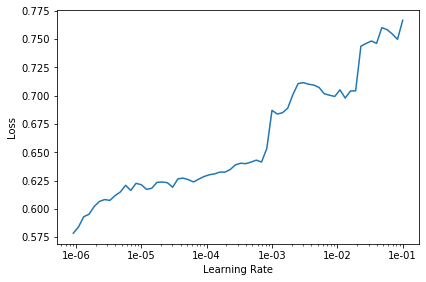

In [24]:
from flair.visual.training_curves import Plotter
plotter = Plotter()
plotter.plot_learning_rate(learning_rate_tsv)

Used 0.9 as the learning rate as it's right in the valley.

In [9]:
trainTransformer(corpus, document_embeddings, label_dict, 9e-1)

2020-06-13 14:07:22,279 ----------------------------------------------------------------------------------------------------
2020-06-13 14:07:22,280 Model: "TextClassifier(
  (document_embeddings): TransformerDocumentEmbeddings(
    (model): DistilBertModel(
      (embeddings): Embeddings(
        (word_embeddings): Embedding(30522, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (transformer): Transformer(
        (layer): ModuleList(
          (0): TransformerBlock(
            (attention): MultiHeadSelfAttention(
              (dropout): Dropout(p=0.1, inplace=False)
              (q_lin): Linear(in_features=768, out_features=768, bias=True)
              (k_lin): Linear(in_features=768, out_features=768, bias=True)
              (v_lin): Linear(in_features=768, out_features=768, bias=True)
              (out_lin): Linear(in